Epoch 1/300


C:\Users\tk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.1001 - val_loss: 0.0707
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0306 - val_loss: 0.0066
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 8/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 9/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0043 - val_loss: 0.0068
Epoch 10/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 11/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 12/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - 

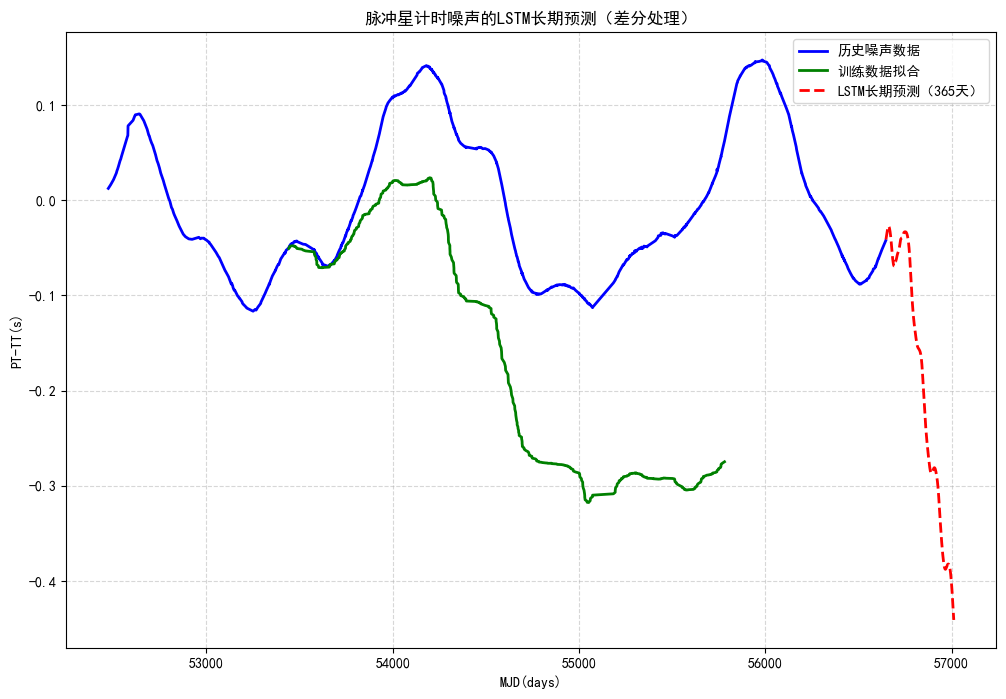

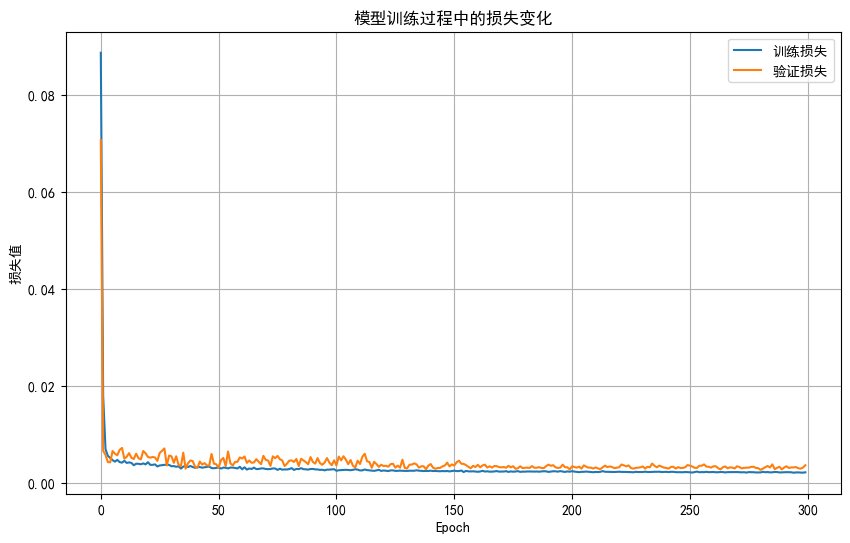

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 设置matplotlib使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
data = pd.read_excel('Attachment 1.xlsx')
data.columns = ['MJD(days)', 'PT-TT(s)']

# 设置MJD(days)为索引
data.set_index(keys='MJD(days)', inplace=True)

# 清理数据，将非数值转换为NaN并删除
data['PT-TT(s)'] = pd.to_numeric(data['PT-TT(s)'], errors='coerce')
data = data.dropna()

# 对数据进行差分处理
diff_data = data['PT-TT(s)'].diff().dropna()

# 数据标准化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(diff_data.values.reshape(-1, 1))

# 准备LSTM的输入数据
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# 增加序列长度以捕捉更长期的模式
seq_length = 120  # 从90增加到120天
X, y = create_sequences(scaled_data, seq_length)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 重塑数据以适应LSTM输入格式 [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 构建更复杂的双向LSTM模型
model = Sequential([
    Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.4),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1)
])

# 编译模型，使用更小的学习率以提高稳定性
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# 训练模型，增加epochs
history = model.fit(X_train, y_train, epochs=300, batch_size=16, 
                   validation_split=0.1, verbose=1)

# 预测训练数据
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)

# 预测未来365天
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(365):
    # 重塑数据用于预测
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # 预测下一个值
    next_pred = model.predict(current_sequence, verbose=0)[0]
    # 确保预测值在[0,1]范围内
    next_pred = np.clip(next_pred, 0, 1)
    # 添加预测值到列表
    predictions.append(next_pred[0])
    # 更新序列
    last_sequence = np.append(last_sequence[1:], next_pred)

# 反向转换预测值
predictions = np.array(predictions).reshape(-1, 1)
predictions = np.clip(predictions, 0, 1)  # 再次确保所有值都在[0,1]范围内
predictions = scaler.inverse_transform(predictions)

# 将差分预测值转换回原始值
original_last_value = data['PT-TT(s)'].iloc[-1]
cumsum_predictions = np.cumsum(predictions)
final_predictions = cumsum_predictions + original_last_value

# 创建预测索引
forecast_index = data.index[-1] + np.arange(1, 366)

# 保存预测结果
forecast_df = pd.DataFrame({
    'MJD(days)': forecast_index,
    'Predicted PT-TT(s)': final_predictions.flatten()
})
forecast_df.to_csv('LSTM长期预测结果.csv', index=False, encoding='utf-8-sig')

# 绘制结果
plt.figure(figsize=(12, 8))

# 绘制历史数据
plt.plot(data.index, data['PT-TT(s)'], label='历史噪声数据', color='blue', linewidth=2)

# 绘制训练数据的拟合结果
train_index = data.index[seq_length:seq_length+len(train_pred)]
cumsum_train_pred = np.cumsum(train_pred.flatten())
final_train_pred = cumsum_train_pred + data['PT-TT(s)'].iloc[seq_length-1]
plt.plot(train_index, final_train_pred, label='训练数据拟合', color='green', linewidth=2)

# 绘制预测结果
plt.plot(forecast_index, final_predictions, label='LSTM长期预测（365天）', color='red', linestyle='--', linewidth=2)

plt.xlabel('MJD(days)')
plt.ylabel('PT-TT(s)')
plt.title('脉冲星计时噪声的LSTM长期预测（差分处理）')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 绘制训练过程中的损失变化
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型训练过程中的损失变化')
plt.xlabel('Epoch')
plt.ylabel('损失值')
plt.legend()
plt.grid(True)
plt.show()